In [106]:
from statistics import mean
from tkinter import Y
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr

In [107]:
data = pd.read_csv("Granite1.csv")

X = data[[" X", " Y", " Hardness(GPa)", " Modulus"]]
tempdf = X.copy()

In [108]:
#extract outliers using 1.5*iqr rule
iqr_multiplier_hard = 1.5 * iqr(X[" Hardness(GPa)"])
third_quar_hard = np.percentile(X[" Hardness(GPa)"], 75)
first_quar_hard = np.percentile(X[" Hardness(GPa)"], 25)
iqr_multiplier_mod = 1.5 * iqr(X[" Modulus"])
third_quar_mod = np.percentile(X[" Modulus"], 75)
first_quar_mod = np.percentile(X[" Modulus"], 25)

outliers = pd.DataFrame(columns=["X","Y","Hardness","Modulus","Index"])

for x in range(len(X[" Hardness(GPa)"])):
    if tempdf[" Hardness(GPa)"][x] > (iqr_multiplier_hard + third_quar_hard) or tempdf[" Hardness(GPa)"][x] < (first_quar_hard - iqr_multiplier_hard):
        outliers.loc[len(outliers.index)] = [float(X[" X"][x]), float(X[" Y"][x]), float(X[" Hardness(GPa)"][x]), float(X[" Modulus"][x]),x]
        tempdf.drop(index=x, inplace=True,axis=0)
    else:
        if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):
            tempdf.drop(index=x,inplace=True)
            outliers.loc[len(outliers.index)] = [X[" X"][x], X[" Y"][x], X[" Hardness(GPa)"][x], X[" Modulus"][x], x]


In [109]:
#linear interpolation
hard_interp=interpolate.interp2d(tempdf[" X"], tempdf[" Y"], tempdf[" Hardness(GPa)"], kind="linear")
mod_interp=interpolate.interp2d(tempdf[" X"], tempdf[" Y"], tempdf[" Modulus"], kind="linear")

for i in range(len(outliers)):
    if outliers["Hardness"][i] > (iqr_multiplier_hard + third_quar_hard) or outliers["Hardness"][i] < (first_quar_hard - iqr_multiplier_hard):
        hard_new = hard_interp(outliers["X"][i],outliers["Y"][i])
        tempdf.loc[outliers["Index"][float(i)]] = [outliers["X"][i], outliers["Y"][i], hard_new[0], outliers["Modulus"][i]]
    if outliers["Modulus"][i] > (iqr_multiplier_mod + third_quar_mod) or outliers["Modulus"][i] < (first_quar_mod - iqr_multiplier_mod):
        mod_new = mod_interp(outliers["X"][i], outliers["Y"][i])
        tempdf.loc[outliers["Index"][float(i)]] = [outliers["X"][i], outliers["Y"][i], outliers["Hardness"][i], mod_new[0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,12 m=93 fp=0.889479 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,12 m=93 fp=3019.455682 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [110]:
#map data to range of [0,1]
max_hard = max(tempdf[" Hardness(GPa)"])
min_hard = min(tempdf[" Hardness(GPa)"])
max_mod =  max(tempdf[" Modulus"])
min_mod = min(tempdf[" Modulus"])
max_x = max(tempdf[" X"])
min_x = min(tempdf[" X"])
max_y = max(tempdf[" Y"])
min_y = min(tempdf[" Y"])

for x in range(len(tempdf)):
    tempdf[" Hardness(GPa)"][x] = (tempdf[" Hardness(GPa)"][x]-min_hard)/(max_hard-min_hard)
    tempdf[" Modulus"][x] = (tempdf[" Modulus"][x]-min_mod)/(max_mod-min_mod)
    if round((tempdf[" Y"][x]-min_y)/(max_y-min_y), 2)==.99:
        tempdf[" Y"][x] = 1
    else:
        tempdf[" Y"][x] = round((tempdf[" Y"][x]-min_y)/(max_y-min_y), 2)
    tempdf[" X"][x] = round((tempdf[" X"][x]-min_x)/(max_x-min_x), 2)
    


In [111]:
#add data points
new_temp = tempdf.copy()

hard_interp_norm=interpolate.interp2d(tempdf[" X"], tempdf[" Y"], tempdf[" Hardness(GPa)"], kind="linear")
mod_interp_norm=interpolate.interp2d(tempdf[" X"], tempdf[" Y"], tempdf[" Modulus"], kind="linear")

test = hard_interp_norm(0.04, 0.07)

new = 21
for i in range(0, new):
    for j in range(0, new):
        hard_new_norm = hard_interp_norm(i/(new-1), j/(new-1))
        mod_new_norm = mod_interp_norm(i/(new-1), j/(new-1))
        new_temp.loc[len(new_temp.index)] = [i/(new-1), j/(new-1), hard_new_norm[0], mod_new_norm[0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=13,12 m=102 fp=0.005242 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=13,12 m=102 fp=0.000343 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


<bound method NDFrame.head of           X     Y   Hardness(GPa)   Modulus  Cluster
0.0    0.00  1.00        0.002015  0.047153        2
1.0    0.05  1.00        0.009253  0.085988        2
2.0    0.10  1.00        0.001673  0.000000        2
3.0    0.20  1.00        0.007041  0.073537        2
5.0    0.40  1.00        0.010996  0.085417        2
...     ...   ...             ...       ...      ...
538.0  1.00  0.80        0.044313  0.230122        0
539.0  1.00  0.85        0.046499  0.155128        0
540.0  1.00  0.90        0.001647  0.080133        0
541.0  1.00  0.95        0.020340  0.180649        0
542.0  1.00  1.00        0.039034  0.282911        0

[543 rows x 5 columns]>


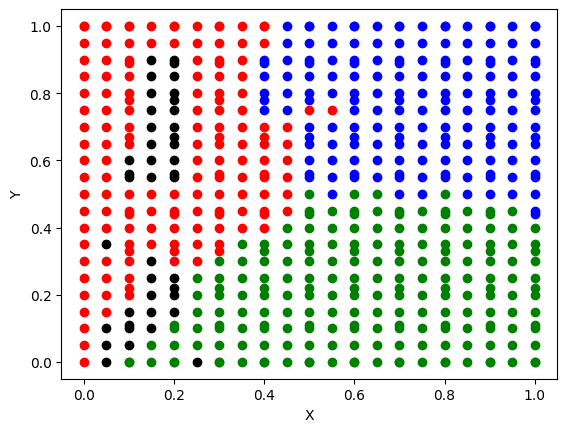

In [112]:
#kmeans
km = KMeans(n_clusters = 4, init="k-means++",max_iter=300,n_init=10,random_state=0)
km.fit(new_temp)
clusters = km.predict(new_temp)
new_temp["Cluster"]=clusters
print(new_temp.head)

color=["blue", "green", "red", "black"]

for i in range(len(new_temp)):
    plt.scatter(new_temp[" X"][i], new_temp[" Y"][i], c = color[new_temp["Cluster"][i]])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()